# House Rocket Project  - The Best House to Buy in the Best Time 
---

# 0.0 IMPORTS 
---

In [96]:
import folium
import warnings
import pandas                  as pd
import seaborn                 as sns
import statsmodels.api         as sm
import statsmodels.formula.api as smf
import numpy                   as np

from matplotlib                import pyplot as plt
from folium.plugins            import HeatMap
from IPython.core.display      import HTML
  
from sklearn.metrics           import mean_absolute_error, mean_squared_error
from sklearn.ensemble          import RandomForestRegressor
from sklearn.linear_model      import LinearRegression
from sklearn.preprocessing     import LabelEncoder, PolynomialFeatures
from sklearn.model_selection   import train_test_split, KFold, RandomizedSearchCV, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.feature_selection import SelectKBest, SelectPercentile, f_regression, RFE, RFECV
from sklearn.svm               import SVR

warnings.filterwarnings('ignore') 

## 0.1. Helper Functions

In [98]:
def mean_absolute_percentage_error( y_true, y_pred ):
    return np.mean( ( np.abs( y_true - y_pred ) / y_true ) )


def  ml_error( model_name, y_test, yhat ):
    mae = mean_absolute_error( y_test, yhat )
    mape = mean_absolute_percentage_error( y_test, yhat )
    rmse = np.sqrt( mean_squared_error( y_test, yhat ) )
    
    return pd.DataFrame( {'Model': model_name, 'MAE': mae, 'MAPE': mape, 'RMSE': rmse}, index=[0] )


def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25,12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>' ) )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [3]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2. House Rocket Sales MindMap

## 0.3. Loading Data

In [4]:
df_raw = pd.read_csv('kc_house_data.csv')

    1. Identify peek at your data
    2. Dimensions of your data
    3. Data Type for each attribute
    4. Descriptive Statistics
       4.1 Central tendency
            4.1.1 Mean, Median, Mode
       4.2 Dispersion

# 1.0. DATA PREPARATION
---

## 1.1 Rename Attributes


In [5]:
df1 = df_raw.copy()
df1.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [6]:
#new columns name
new_cols = ['id', 'date', 'price', 'bedrooms', 'bathrooms', 'built_area', 'lot_area', 'floors', 'waterfront', 'view', 'condition', 'grade', 'area_above', 'area_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15']
#rename 
df1.columns = new_cols 
# ERROR

## 1.2. Format of Attributes

In [7]:
df1.dtypes

id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
built_area         int64
lot_area           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
area_above         int64
area_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object

In [8]:
df1['bathrooms'] = np.round(df1['bathrooms'], 1)

#convert date from string to datetime64
df1['date'] = pd.to_datetime( df1['date'])

df1.head()

,id,date,price,bedrooms,bathrooms,built_area,lot_area,floors,waterfront,view,condition,grade,area_above,area_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,2014-10-13,221900.0,3,1.0,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,2014-12-09,538000.0,3,2.2,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,2015-02-25,180000.0,2,1.0,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,2014-12-09,604000.0,4,3.0,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,2015-02-18,510000.0,3,2.0,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [9]:
df1.dtypes

id                        int64
date             datetime64[ns]
price                   float64
bedrooms                  int64
bathrooms               float64
built_area                int64
lot_area                  int64
floors                  float64
waterfront                int64
view                      int64
condition                 int64
grade                     int64
area_above                int64
area_basement             int64
yr_built                  int64
yr_renovated              int64
zipcode                   int64
lat                     float64
long                    float64
sqft_living15             int64
sqft_lot15                int64
dtype: object

# 2.0. DESCRIBE DATA
---

In [10]:
 df2 = df1.copy()

## 2.1. Data Dimensions

In [11]:
print( 'Number of Rows: {}'.format( df2.shape[0] ) )
print( 'Number of Columns: {}'.format ( df2.shape[1] ) )

Number of Rows: 21613
Number of Columns: 21


## 2.2. Data Type Attributes


In [12]:
print(df2.dtypes)

id                        int64
date             datetime64[ns]
price                   float64
bedrooms                  int64
bathrooms               float64
built_area                int64
lot_area                  int64
floors                  float64
waterfront                int64
view                      int64
condition                 int64
grade                     int64
area_above                int64
area_basement             int64
yr_built                  int64
yr_renovated              int64
zipcode                   int64
lat                     float64
long                    float64
sqft_living15             int64
sqft_lot15                int64
dtype: object


## 2.3. Number of NA

In [13]:
df2.isna().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
built_area       0
lot_area         0
floors           0
waterfront       0
view             0
condition        0
grade            0
area_above       0
area_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

In [14]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
id               21613 non-null int64
date             21613 non-null datetime64[ns]
price            21613 non-null float64
bedrooms         21613 non-null int64
bathrooms        21613 non-null float64
built_area       21613 non-null int64
lot_area         21613 non-null int64
floors           21613 non-null float64
waterfront       21613 non-null int64
view             21613 non-null int64
condition        21613 non-null int64
grade            21613 non-null int64
area_above       21613 non-null int64
area_basement    21613 non-null int64
yr_built         21613 non-null int64
yr_renovated     21613 non-null int64
zipcode          21613 non-null int64
lat              21613 non-null float64
long             21613 non-null float64
sqft_living15    21613 non-null int64
sqft_lot15       21613 non-null int64
dtypes: datetime64[ns](1), float64(5), int64(15)
memory usage: 3.5 MB


In [15]:
#Drop id and date columns 
#df2 = df2.drop(['id', 'date'], axis=1)

## 2.4. Descriptive Statistics

In [16]:
#separate the categorical from numerical features
num_attributes  = df2.select_dtypes( include = ['int64', 'float64'] )
cat_attributes = df2.select_dtypes( exclude = ['int64', 'float64', 'datetime64'] )

print( 'Num of Categorical : {}'.format( cat_attributes.shape[1]) )
print( 'Num of Numerical: {}'.format( num_attributes.shape[1] ) )

Num of Categorical : 0
Num of Numerical: 20


### 2.4.1 Central Tendency and Dispersion


###### 2.4.1.1. Numerical Attributes


In [17]:
#Measure of Central Tendency
ct1 = pd.DataFrame( num_attributes.apply( mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( median ) ).T
#ct3 = pd.DataFrame( num_attributes.apply( lambda x: x.mode() ) )

# Dispersion
d1 = pd.DataFrame( num_attributes.apply( std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T


m = pd.concat( [ct1, ct2, d1, d2, d3, d4, d5, d6] ).T.reset_index()
print(m)
m.columns = ['attributes', 'mean', 'median','standard_deviation', 'min', 'max', 'range', 'kurtosis', 'skew']

#Mode and ct3 removed because of error and mismatch

            index             0             0             0             0             0             0           0          0
0              id  4.580302e+09  3.904930e+09  2.876499e+09  1.000102e+06  9.900000e+09  9.899000e+09   -1.260542   0.243329
1           price  5.400881e+05  4.500000e+05  3.671187e+05  7.500000e+04  7.700000e+06  7.625000e+06   34.585540   4.024069
2        bedrooms  3.370842e+00  3.000000e+00  9.300403e-01  0.000000e+00  3.300000e+01  3.300000e+01   49.063653   1.974300
3       bathrooms  2.118808e+00  2.200000e+00  7.668581e-01  0.000000e+00  8.000000e+00  8.000000e+00    1.334690   0.508751
4      built_area  2.079900e+03  1.910000e+03  9.184196e+02  2.900000e+02  1.354000e+04  1.325000e+04    5.243093   1.471555
5        lot_area  1.510697e+04  7.618000e+03  4.141955e+04  5.200000e+02  1.651359e+06  1.650839e+06  285.077820  13.060019
6          floors  1.494309e+00  1.500000e+00  5.399764e-01  1.000000e+00  3.500000e+00  2.500000e+00   -0.484723   0.616177


In [18]:
num_attributes.describe().T

,count,mean,std,min,25%,50%,75%,max
id,21613.0,4.580302e+09,2.876566e+09,1.000102e+06,2.123049e+09,3.904930e+09,7.308900e+09,9.900000e+09
price,21613.0,5.400881e+05,3.671272e+05,7.500000e+04,3.219500e+05,4.500000e+05,6.450000e+05,7.700000e+06
bedrooms,21613.0,3.370842e+00,9.300618e-01,0.000000e+00,3.000000e+00,3.000000e+00,4.000000e+00,3.300000e+01
bathrooms,21613.0,2.118808e+00,7.668758e-01,0.000000e+00,1.800000e+00,2.200000e+00,2.500000e+00,8.000000e+00
built_area,21613.0,2.079900e+03,9.184409e+02,2.900000e+02,1.427000e+03,1.910000e+03,2.550000e+03,1.354000e+04
lot_area,21613.0,1.510697e+04,4.142051e+04,5.200000e+02,5.040000e+03,7.618000e+03,1.068800e+04,1.651359e+06
floors,21613.0,1.494309e+00,5.399889e-01,1.000000e+00,1.000000e+00,1.500000e+00,2.000000e+00,3.500000e+00
waterfront,21613.0,7.541757e-03,8.651720e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
view,21613.0,2.343034e-01,7.663176e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00
condition,21613.0,3.409430e+00,6.507430e-01,1.000000e+00,3.000000e+00,3.000000e+00,4.000000e+00,5.000000e+00


# 3.0. FEATURE ENGINEERING
---

# 4.0 EDA - EXPLORATION DATA ANALYSIS
---

In [24]:
df3 = df2.copy()

## 4.1. Hypothesis MindMap

![title](img/House_rocket_sales.png)

## 4.2. Univariate Analysis

### 4.2.1. Response Variable

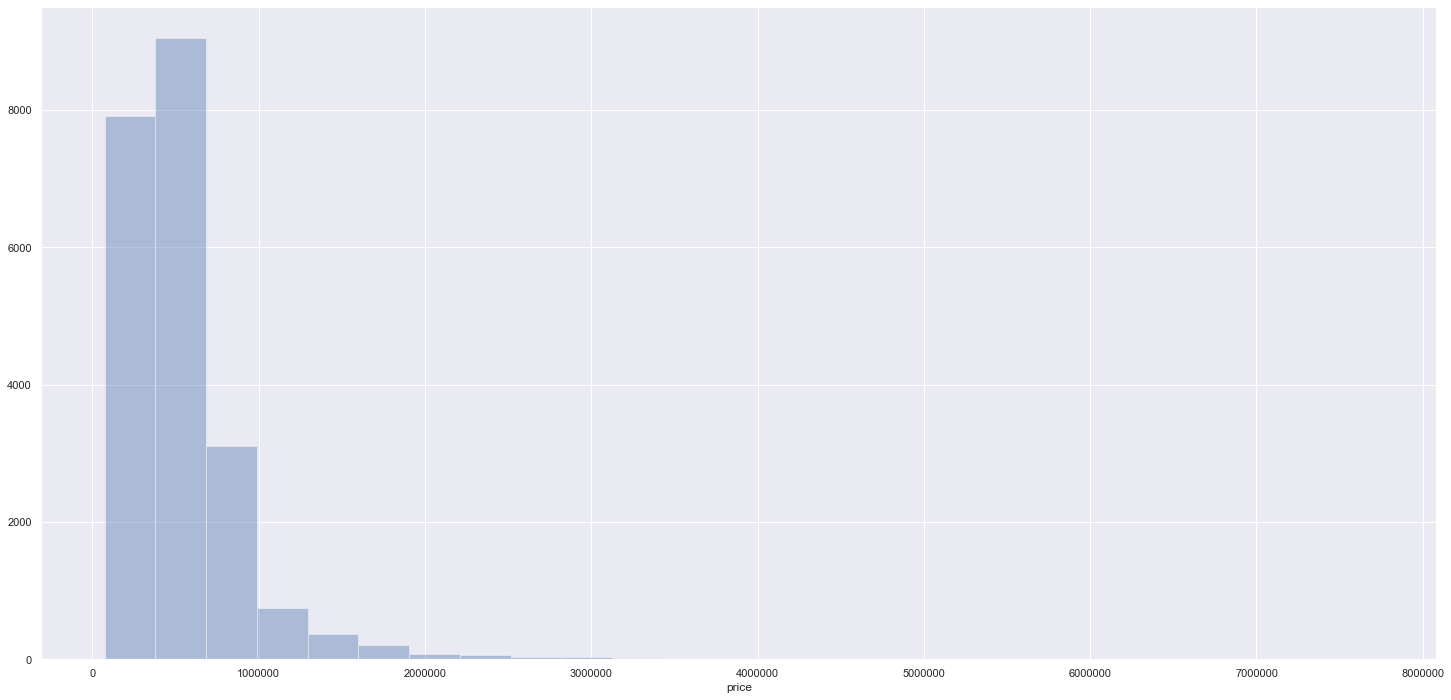

In [25]:
sns.distplot( df3['price'], kde=False, bins=25 );

### 4.2.2. Numerical Predictors

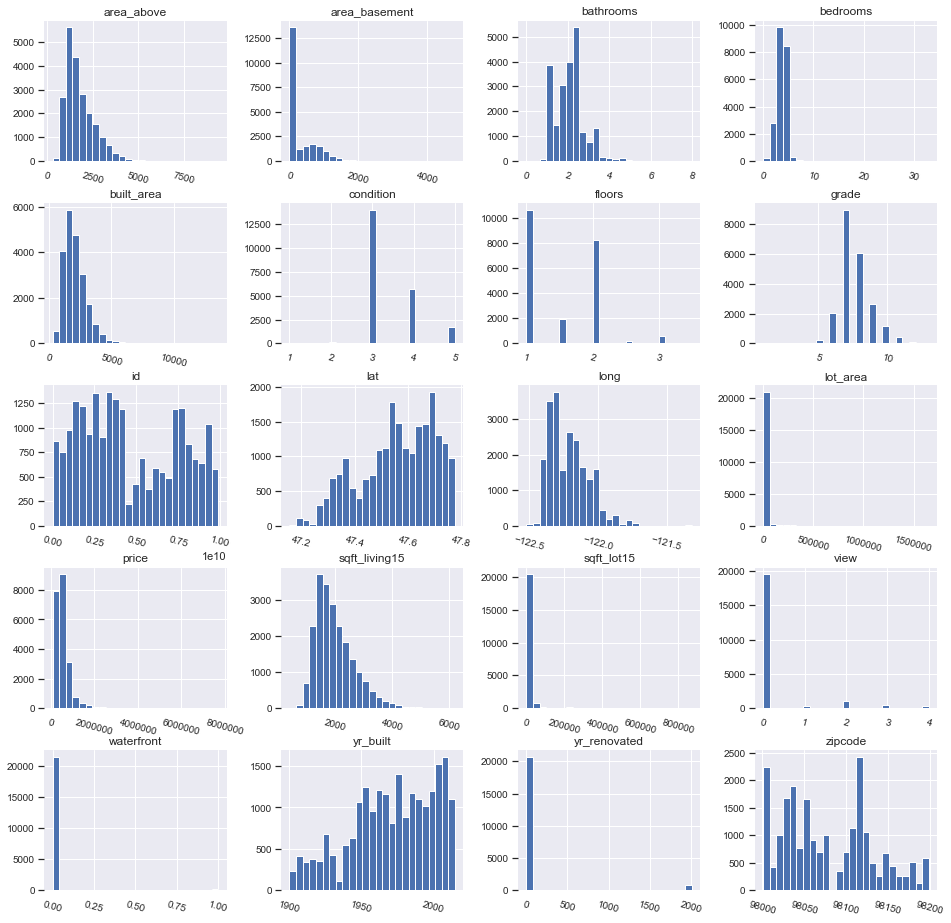

In [26]:
h = df3.hist(bins=25, figsize=(16,16), xlabelsize='10', ylabelsize='10', xrot=-15)

sns.despine(left=True, bottom=True)
[x.title.set_size(12) for x in h.ravel()];
[x.yaxis.tick_left() for x in h.ravel()];

## 4.3. Bivariate Analysis

In [27]:
df3.head()

,id,date,price,bedrooms,bathrooms,built_area,lot_area,floors,waterfront,view,condition,grade,area_above,area_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,2014-10-13,221900.0,3,1.0,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,2014-12-09,538000.0,3,2.2,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,2015-02-25,180000.0,2,1.0,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,2014-12-09,604000.0,4,3.0,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,2015-02-18,510000.0,3,2.0,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


### 4.3.1. Numerical Predictors

### 4.3.1.1. price x bedrooms

##### Bedrooms Hypothesis 

Houses with 2+ bedrooms should have cost more because houses with 2+ bedrooms usually cost more than house with only 1 bedroom.

This hypothesis is correct, however houses with 8+ bathrooms has decresead and 10+ bathrooms maintain a steady line between 6 millions to 4 millions.

This graph represents that houses with 2+ bedrooms compared to price it shows a higher cost, and from 5 to 8 bedrooms has a price spike over 1 million.

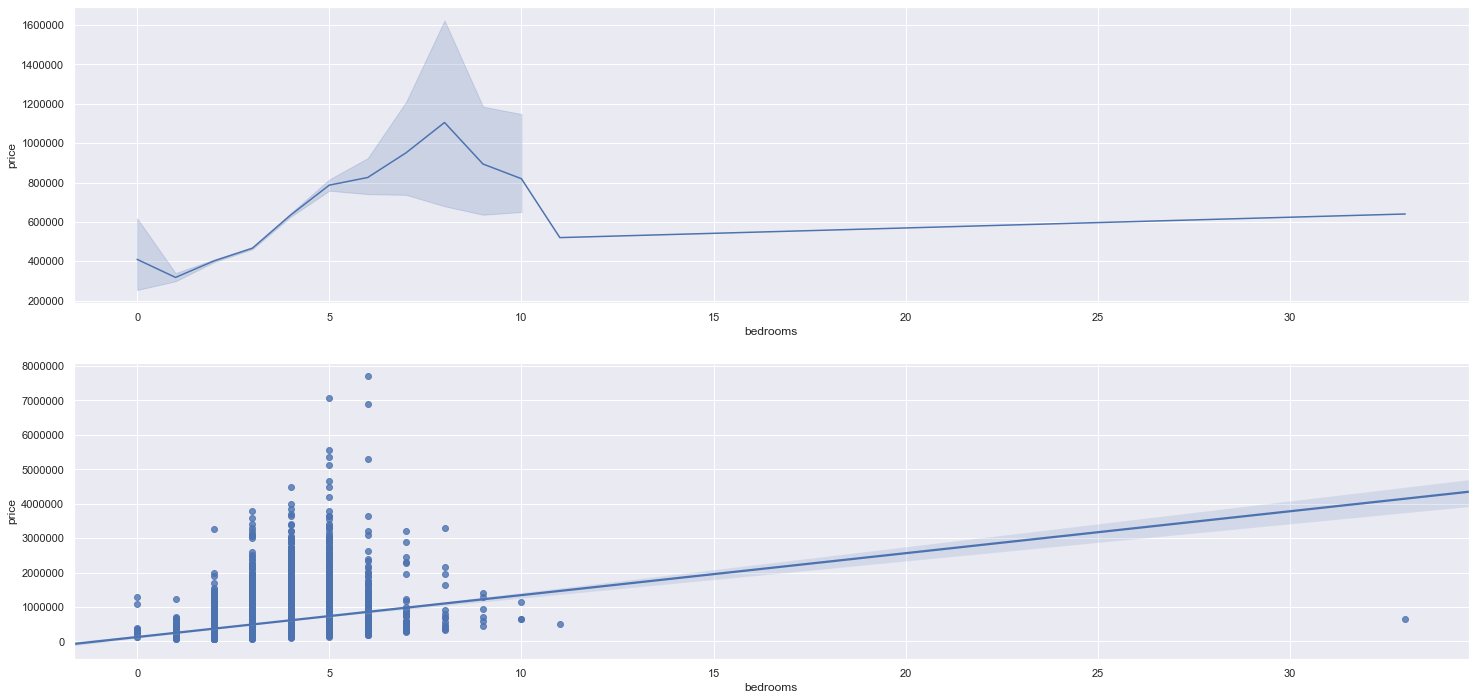

In [28]:
plt.subplot( 2, 1, 1)
sns.lineplot( x='bedrooms', y='price', data=df3 );

plt.subplot( 2, 1, 2 )
sns.regplot( x='bedrooms', y='price', data=df3 );

### 4.3.1.2. price x bathrooms

#### Bathrooms Hypothesis
Houses with 1+ bathrooms should have a higher cost because more bathrooms in a house adds value to it. 

This hypothesis is correct, however there are a few houses that shows otherwise (**investigate**).

This Graph represents that up to 3 bathrooms there is a slightly increase in price 4+ bathrooms that reaches 1 million and more bathrooms vary from 2 millions to 3 millions.
There is a case where 7+ bathrooms has a heavy fall in price (**important**).

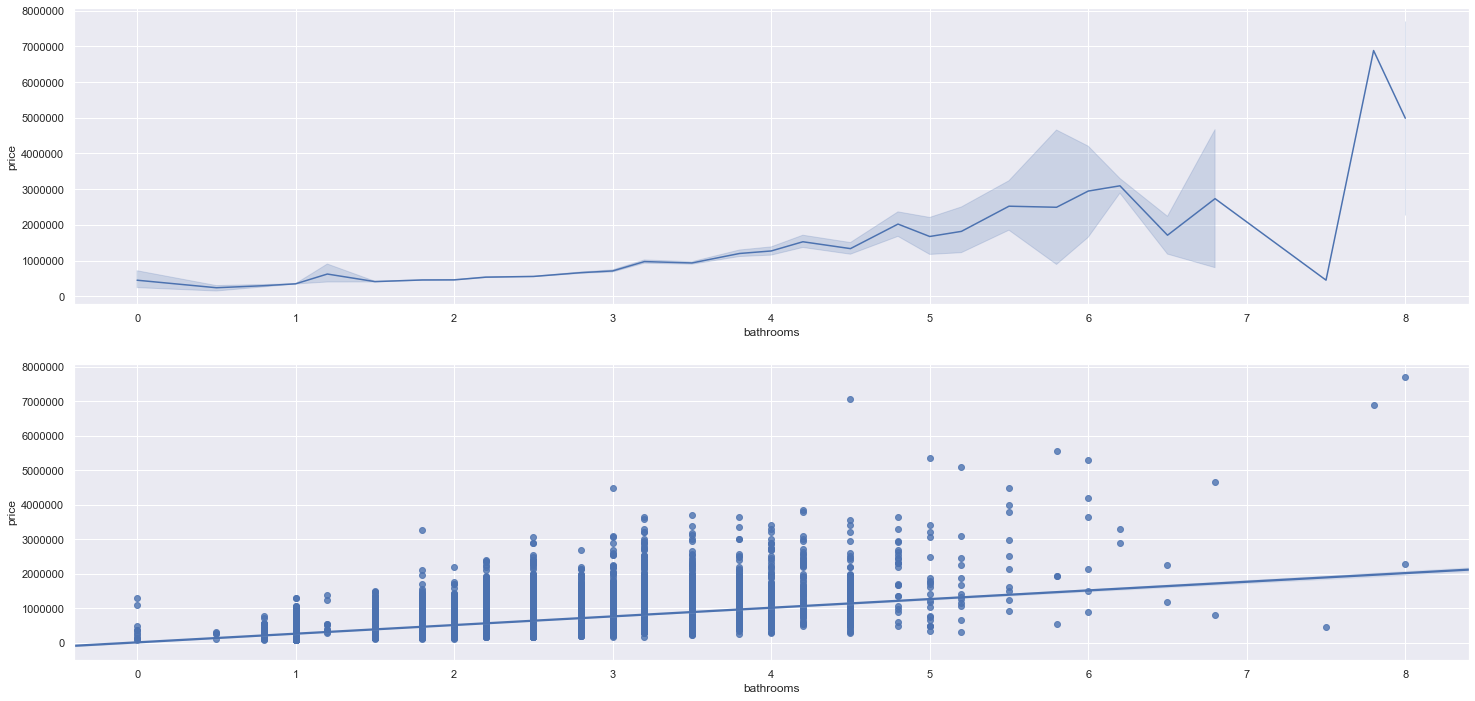

In [29]:
plt.subplot( 2, 1, 1 )
sns.lineplot( x='bathrooms', y='price', data=df3 );

plt.subplot( 2, 1, 2 )
sns.regplot( x='bathrooms', y='price', data=df3);

### 4.3.1.3. price x built_area

#### Built_area  Hypothesis

Houses with higher square footage should have cost more because houses with more space adds more value to it.

This Hypothesis is incorrect, nonetheless some houses which has bigger size in sqft, other houses in the same range has a price fall.

This Graph represents that there is a great variance among all sizes of square footage area.

There are several houses from from 4000 to 8000 sqft below 1 million and should be taken into consideration, one outlier with almost 14000 sqft below 3 millions. 

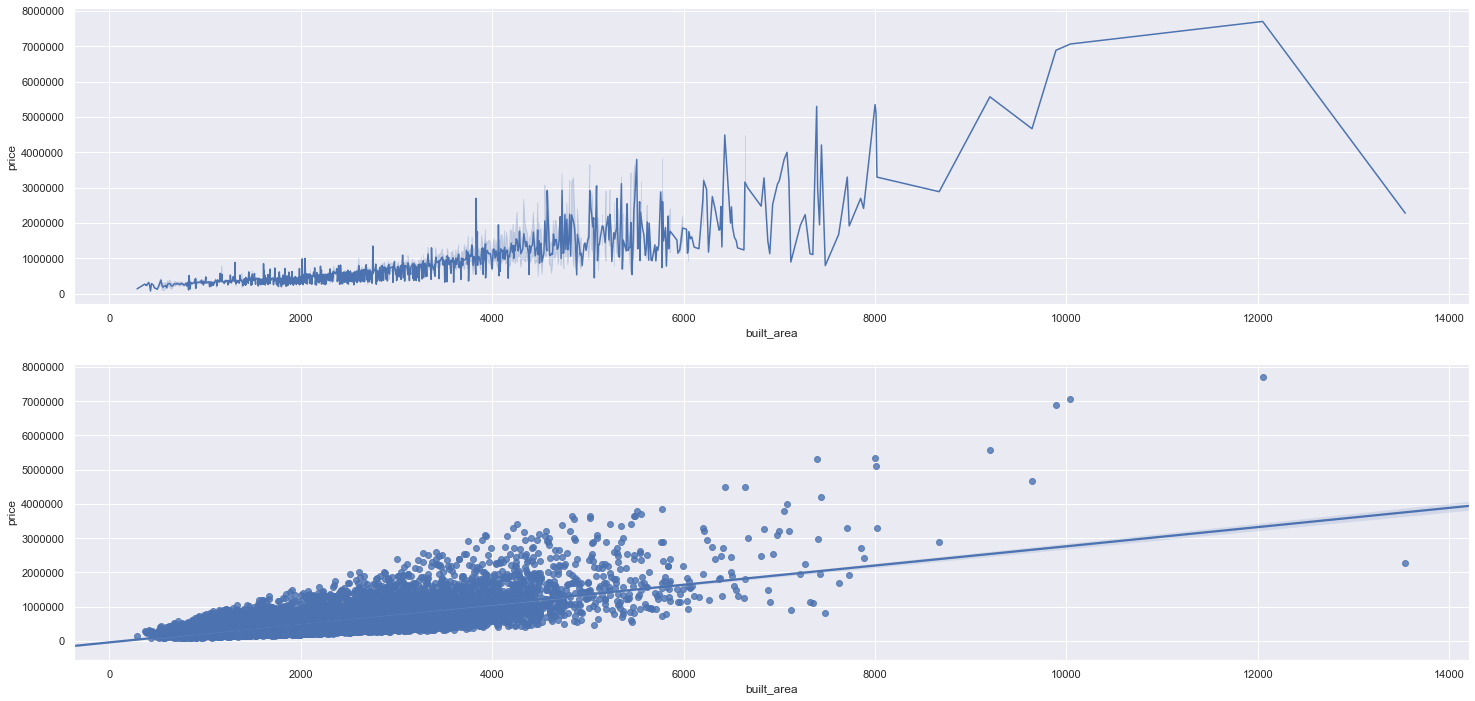

In [30]:
plt.subplot( 2, 1, 1)
sns.lineplot( x='built_area', y='price', data=df3 );

plt.subplot( 2, 1, 2 )
sns.regplot( x='built_area', y='price', data=df3 );

### 4.3.1.4. price x lot_area

#### Lot_area Hypothesis

Houses with high square footage of the lot should have cost more because the higher the space it adds more value to it.

This hypothesis is incorrect, houses with less lot_area has higher prices.

This graph represents that a great number of houses with less than 100 000 sqft reaches high values.


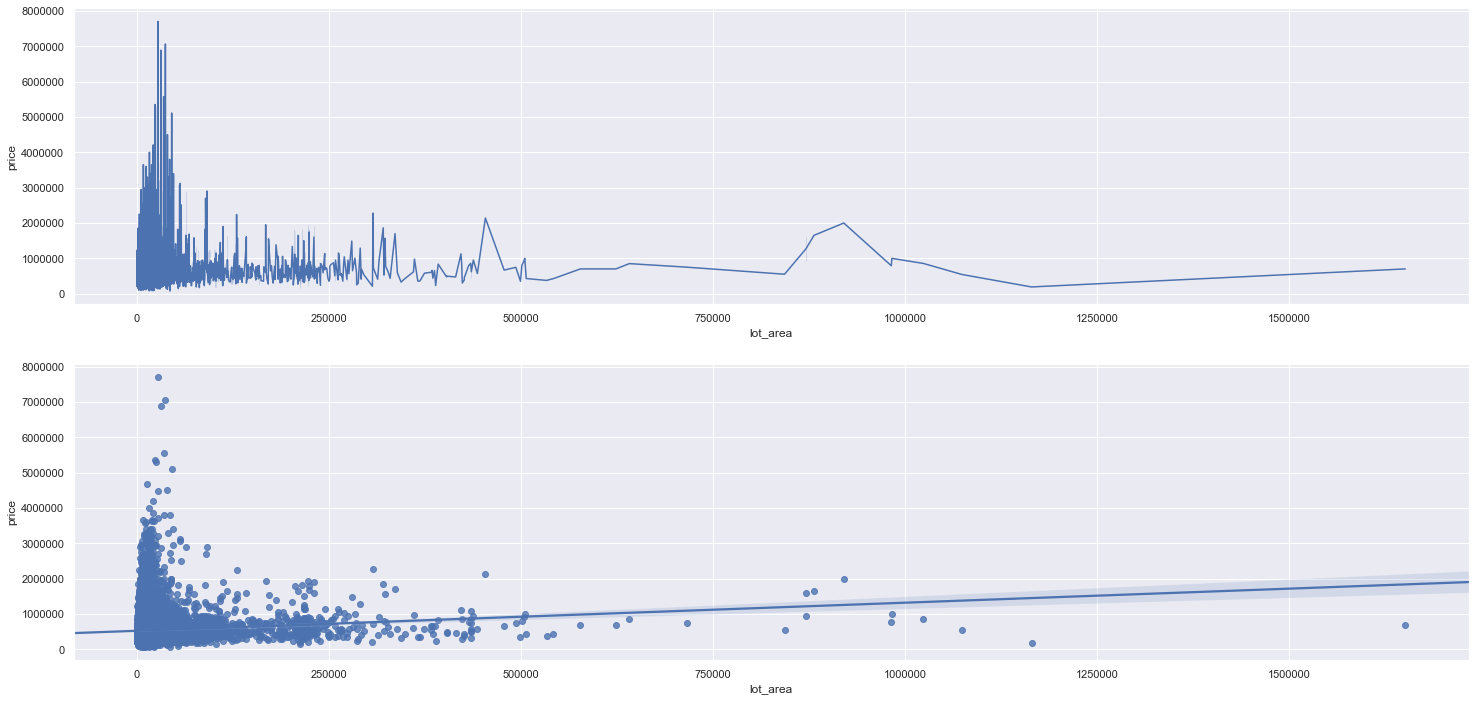

In [31]:
plt.subplot( 2, 1, 1)
sns.lineplot( x='lot_area', y='price', data=df3 );

plt.subplot( 2, 1, 2 )
sns.regplot( x='lot_area', y='price', data=df3 );

### 3.2.1.5. price x floors

#### Floors hypothesis
Houses with second floor should have higher cost because another floor adds value to the house.

This hypothesis is correct, however houses with 3+ floors prices fall.

This graph indicates that houses with 2 to 2.5 floors has higher prices than the rest.

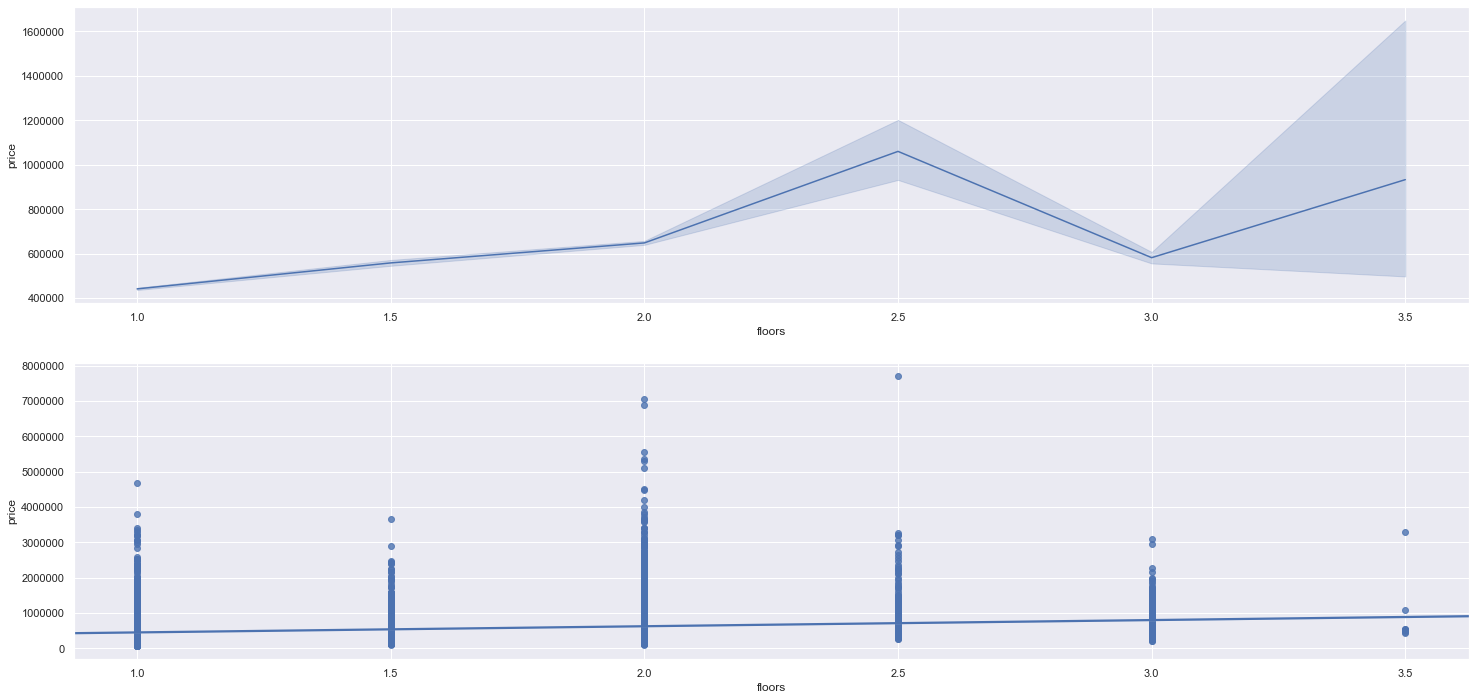

In [32]:
plt.subplot( 2, 1, 1)
sns.lineplot( x='floors', y='price', data=df3 );

plt.subplot( 2, 1, 2 )
sns.regplot( x='floors', y='price', data=df3 );

### 3.2.1.6. price x waterfront

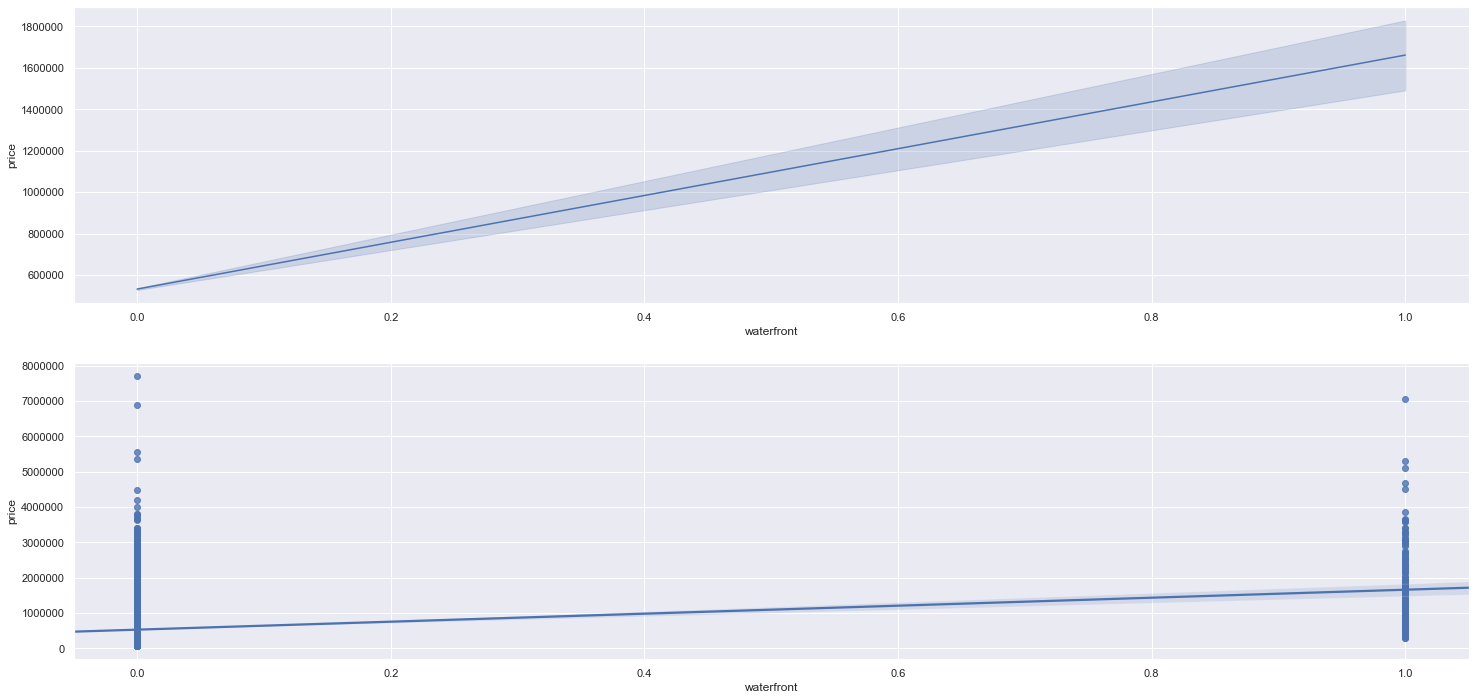

In [33]:
plt.subplot( 2, 1, 1)
sns.lineplot( x='waterfront', y='price', data=df3 );

plt.subplot( 2, 1, 2 )
sns.regplot( x='waterfront', y='price', data=df3 );

### 3.2.1.7. price x view

#### View hypothesis
Houses with higher number of view should have higher cost because customers consider this option which adds value to it.

This hypothesis is correct, view is based from 0 to 4, which 4 is the highest number whereas prices follows increasing with view numbers.

This graph represents the number of views that keep increasing with along the number graded, note that houses which cost millions is included in this graphic.

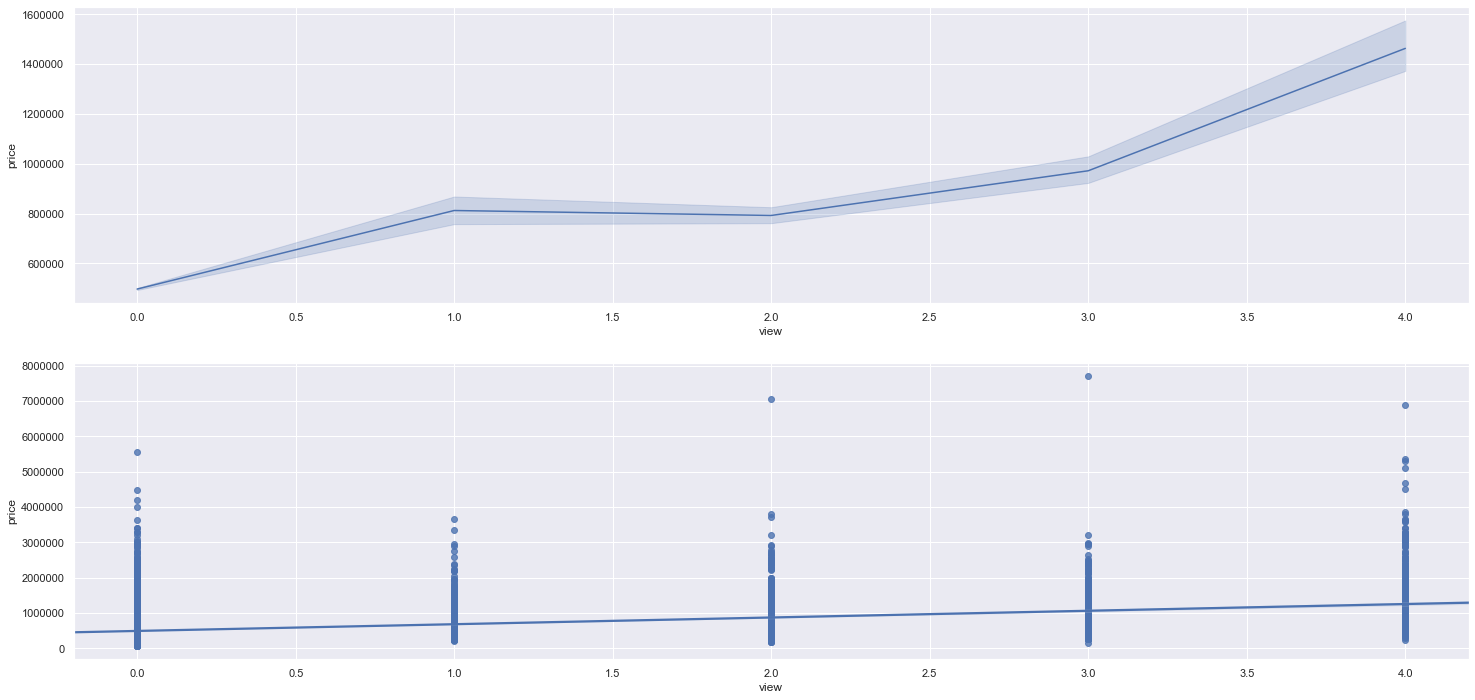

In [34]:
plt.subplot( 2, 1, 1)
sns.lineplot( x='view', y='price', data=df3 );

plt.subplot( 2, 1, 2 )
sns.regplot( x='view', y='price', data=df3 );

### 3.2.1.8. price x condition

#### Conditions hypothesis
Houses with high conditions should have cost more than house with low condition, because as the condition increases should the price as well.

This hypothesis is correct, even though most of the houses has condition nr 3 compared to nr 4 and 5.

This graph represents that house with low condition ( 1, 2 ) are cheaper than houses ( 3, 4, 5), and another fact is that some houses in the same range are slightly cheaper.

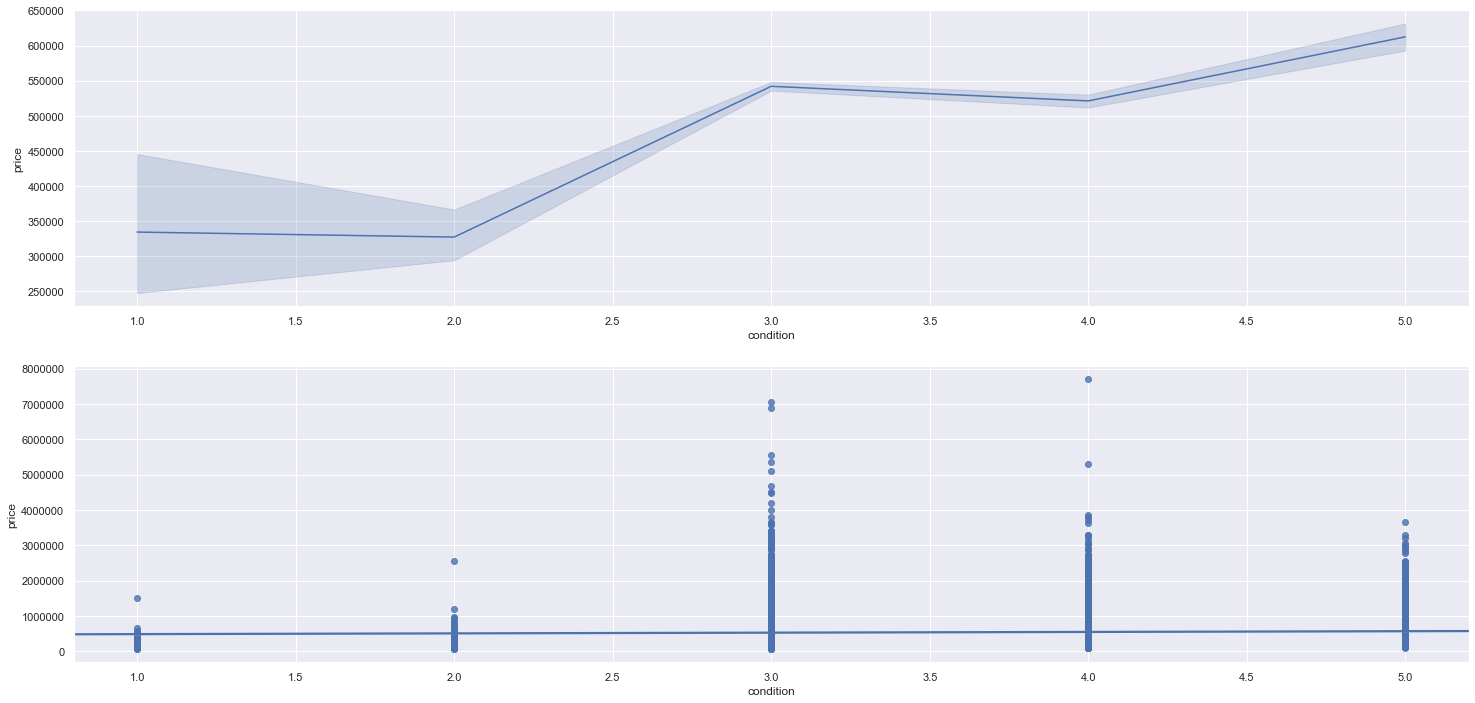

In [35]:
plt.subplot( 2, 1, 1)
sns.lineplot( x='condition', y='price', data=df3 );

plt.subplot( 2, 1, 2 )
sns.regplot( x='condition', y='price', data=df3 );

### 3.2.1.9. price x grade

#### Grade hypothesis

Houses that have been graded higher should have cost more because of the overall experience of the customer in the house.

This hypothesis is correct, price increases as along with the grade.

This graph represent the increasing price based on the grade of a house, several houses that cost less than 2 millions has been graded up to 13 and it is likely to affect the price.

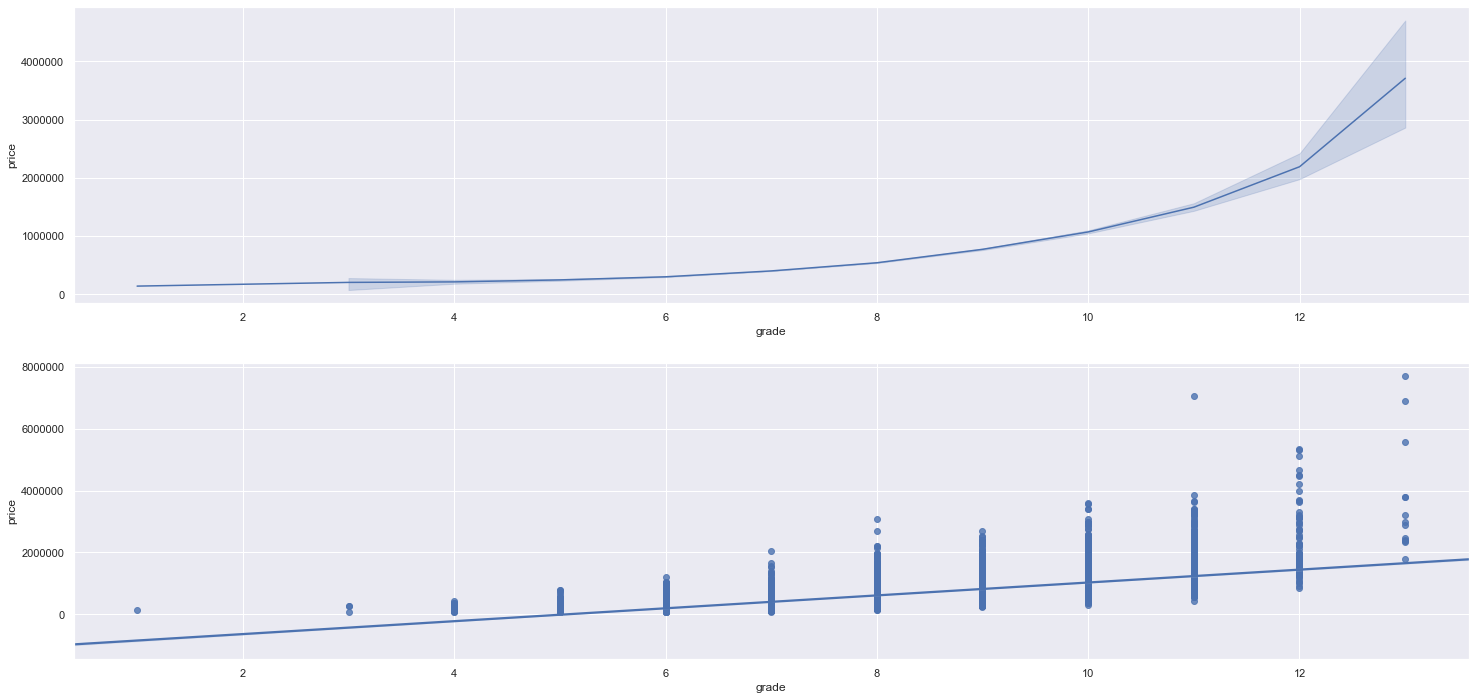

In [36]:
plt.subplot( 2, 1, 1)
sns.lineplot( x='grade', y='price', data=df3 );

plt.subplot( 2, 1, 2 )
sns.regplot( x='grade', y='price', data=df3 );

### 3.2.2. price x area_above

#### Attic (Above) hypothesis

Houses that have an Attic or second floor should have cost more because of the extra space which includes more value to a house.

This hypothesis is incorrect, even though there an increase of price at the same time prices vary decreasing in all range scale.

This graph represent the square footage of a second floor or an Attic related to the price.

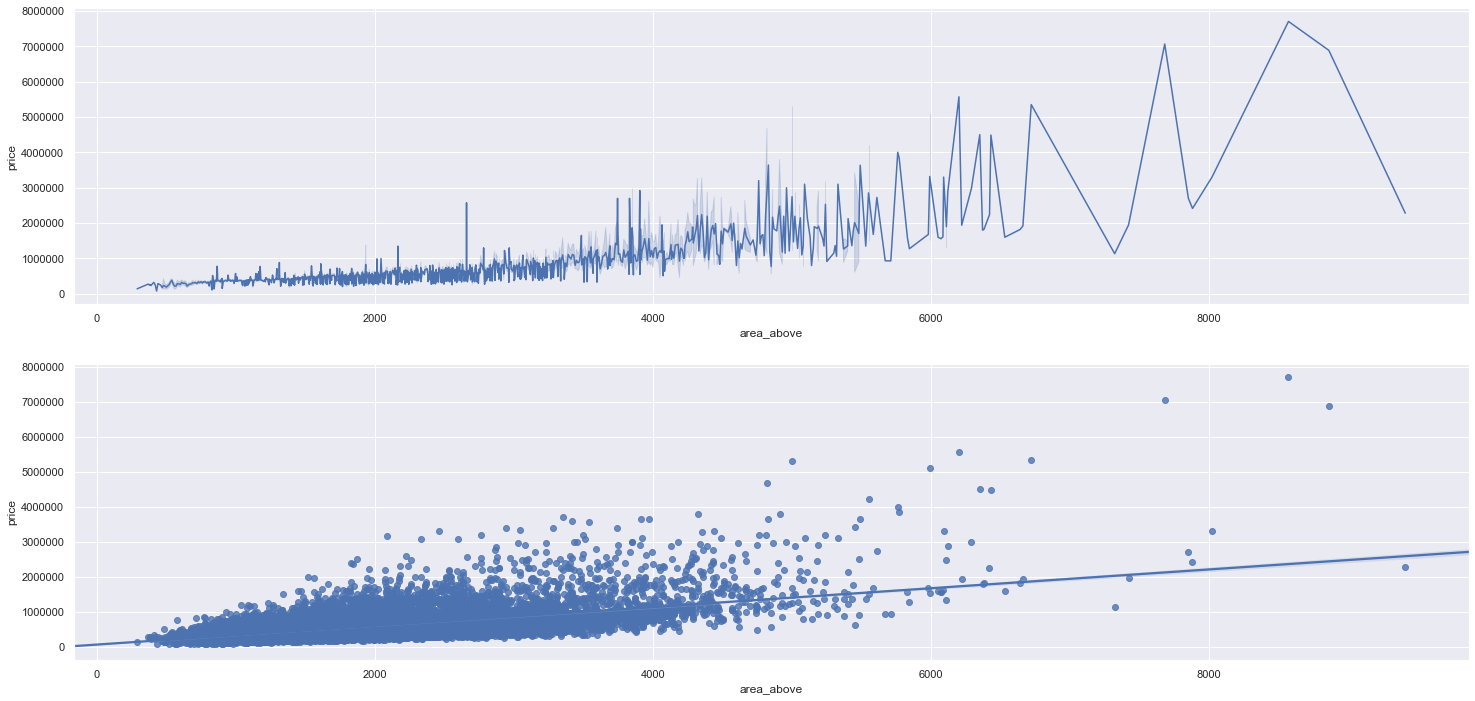

In [37]:
plt.subplot( 2, 1, 1)
sns.lineplot( x='area_above', y='price', data=df3 );

plt.subplot( 2, 1, 2 )
sns.regplot( x='area_above', y='price', data=df3 );

### 3.2.2.1. price x basement

#### Basement Hypothesis

Houses that have a basement should have a higher cost because of the extra space and storage a basement supplies.

This hypothesis is incorrect, although several houses have a spike in prices the overall houses keep a slightly change in price and the keep the range from 1 to 2 millions. 

This graph represents the relationship between square footage of basement related to prices.



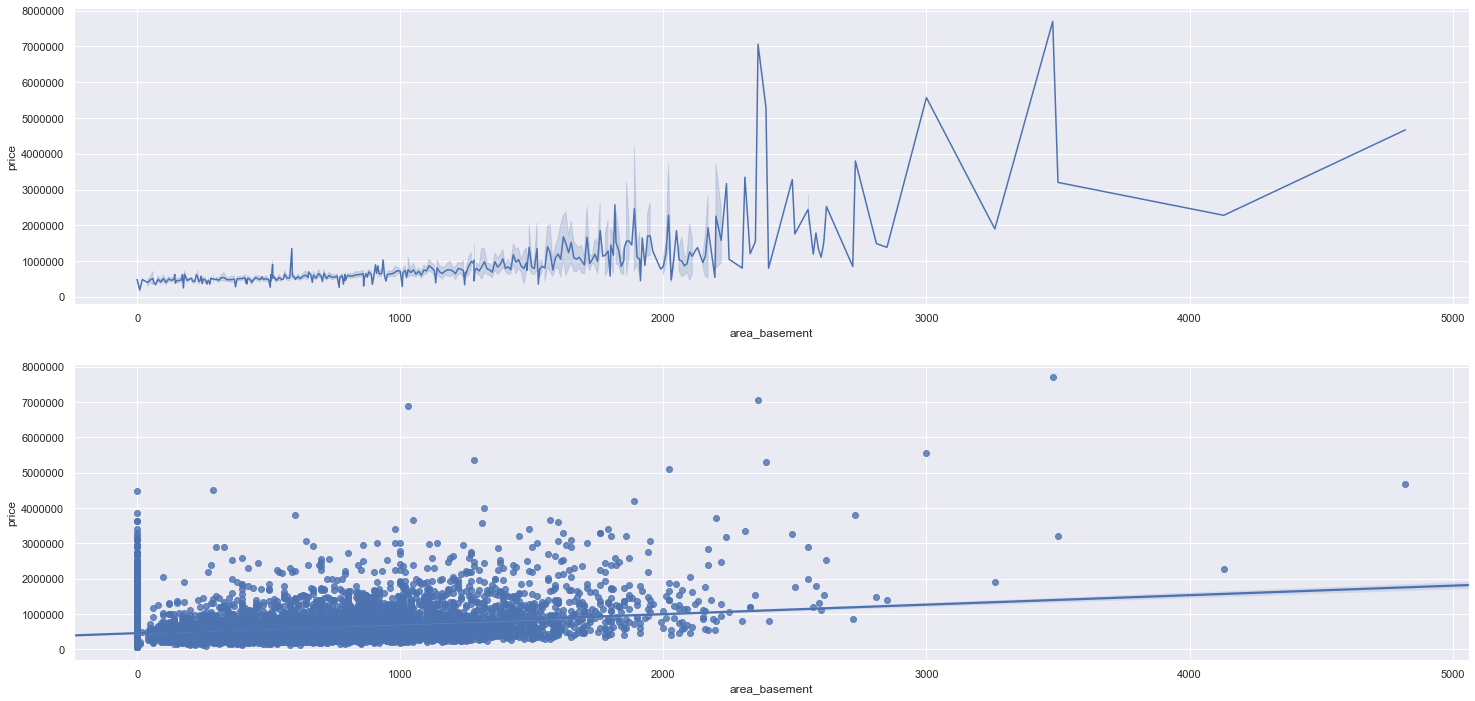

In [38]:
plt.subplot( 2, 1, 1)
sns.lineplot( x='area_basement', y='price', data=df3 );

plt.subplot( 2, 1, 2 )
sns.regplot( x='area_basement', y='price', data=df3 );

### 3.2.2.2. price x yr_built

#### Year built hipothesis

Houses with more than 50 year old should have cost less because old houses probably needs renovation.

This hypothesis is incorrect, there a steady price range according to the graphic which shows from 1920 up to 2000, however some houses built after 2000s has a price spike.

This graph represents the relationship between prices and year that a house was built.

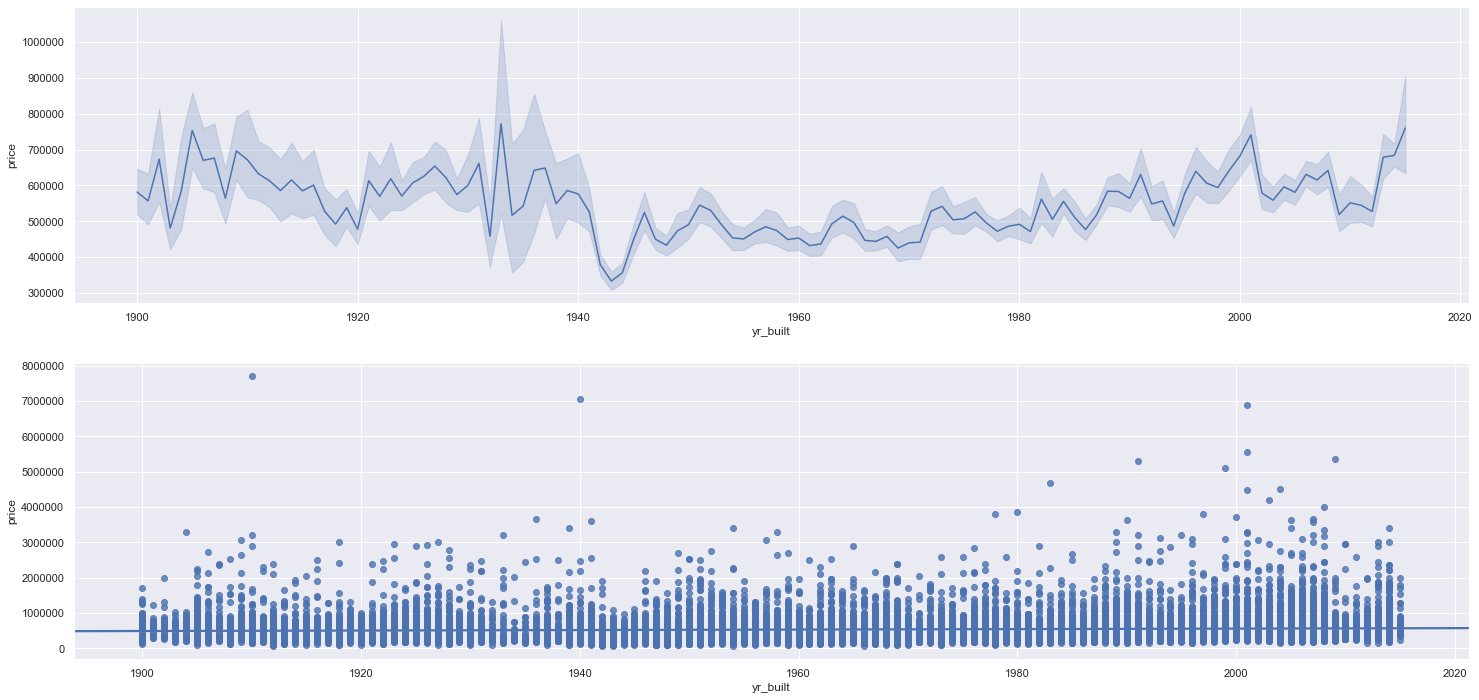

In [39]:
plt.subplot( 2, 1, 1)
sns.lineplot( x='yr_built', y='price', data=df3 );

plt.subplot( 2, 1, 2 )
sns.regplot( x='yr_built', y='price', data=df3 );

### 3.2.2.3. price x yr_renovated

#### Year renovated hypothesis

Houses with renovation should cost more because a renovation usually adds value to the house price.

This hypothesis is correct, several houses renovated next to the year 2000 increased their value despite several other had no change.

This graphic shows the relationship between houses renovated towards and of 1990 and beginning of 2000 onwards has increased the value.

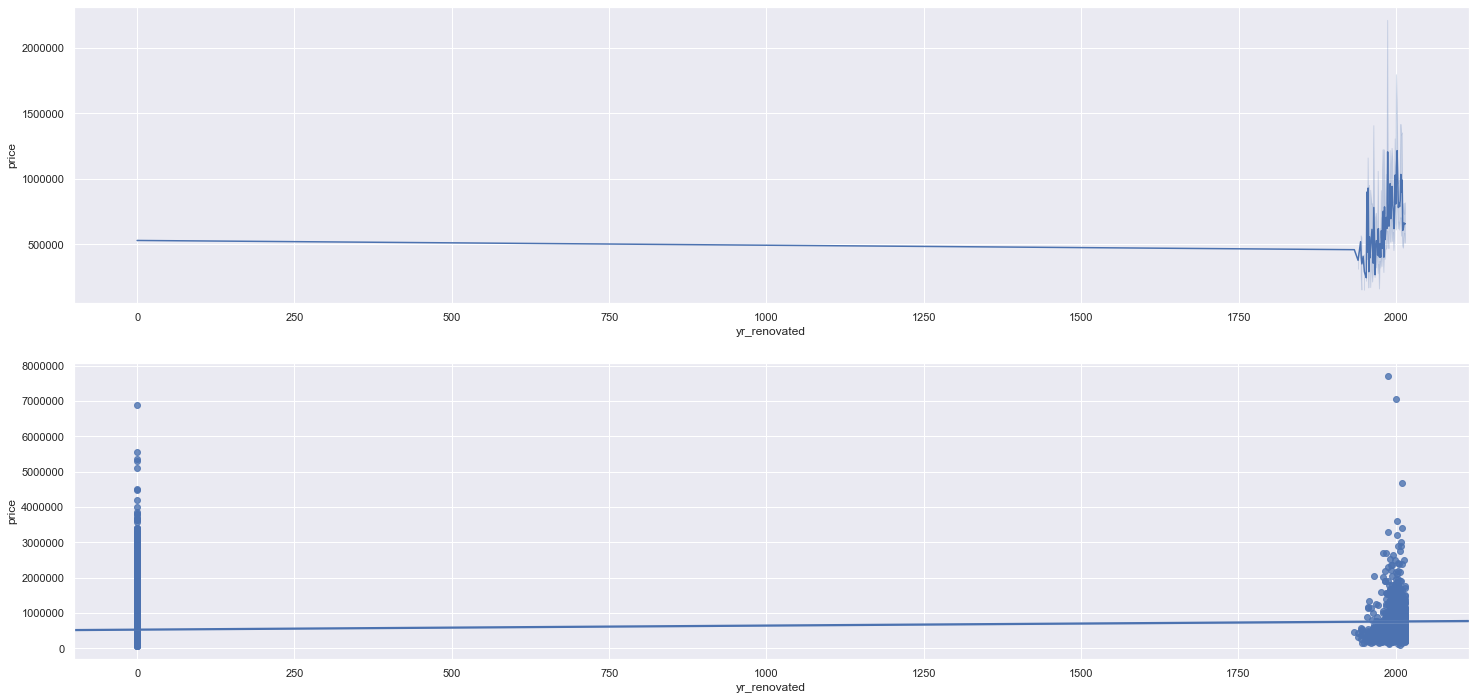

In [40]:
plt.subplot( 2, 1, 1)
sns.lineplot( x='yr_renovated', y='price', data=df3 );

plt.subplot( 2, 1, 2 )
sns.regplot( x='yr_renovated', y='price', data=df3 );

### 3.2.2.4. price x zipcode

#### Zipcode hypothesis

Houses located in wealthy zipcodes should have cost more because wealthy neighbourhoods increases the value of a house.

This hypothesis is correct, prices compared to zipcodes, suburbs such as Bellevue, Bridle Trails, Bel-Red, Woodridge are wealthy zipcodes and house in these areas are more expensive.

This graphs represents the relationship between zipcodes and prices.
 
Example of others wealthy zipcodes are Kirkland, Yarrow Point, South Juanita, Highlands, South Rose Hill, Willow-Rose Hill, Moss Bay, Central Houghton.



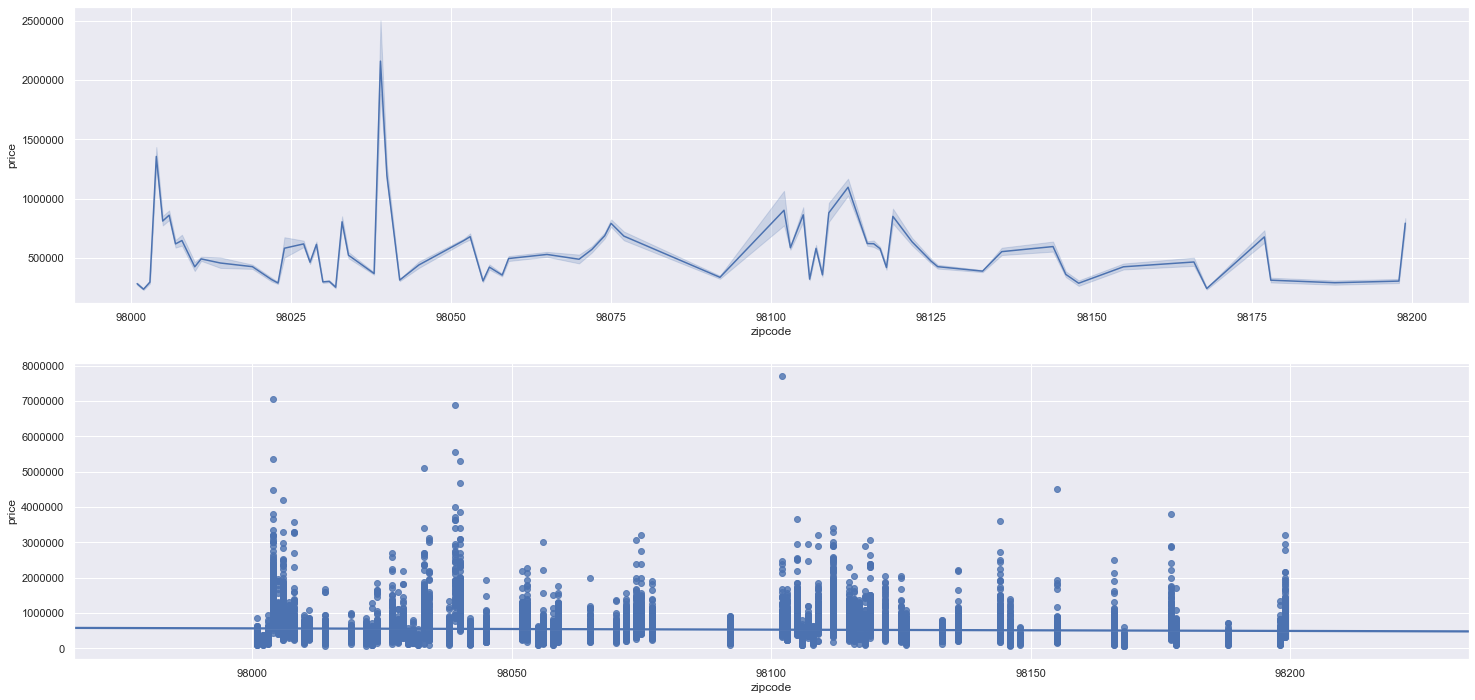

In [41]:
plt.subplot( 2, 1, 1)
sns.lineplot( x='zipcode', y='price', data=df3 );

plt.subplot( 2, 1, 2 )
sns.regplot( x='zipcode', y='price', data=df3 );

### 3.2.2.5. price x lat

#### Lat hypothesis

Houses that are located in certains lattitude such as wealthy or strategic areas should have cost more because houses with good location adds more value.

This hypothesis is correct, the center of seattle lat is 47.6 and its surrounds which is closer to the cbd and lake washington.

This graphics represent the relationship between the lattitude location compared to prices.

Note: locations between lat 47.6 to 47.7 accomodates a great number of houses with higher prices.

KeyboardInterrupt: 

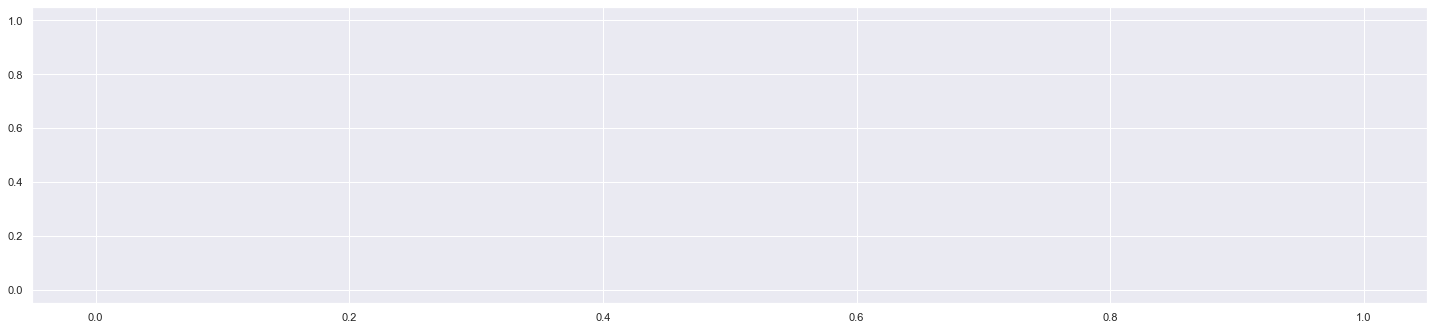

In [42]:
plt.subplot( 2, 1, 1)
sns.lineplot( x='lat', y='price', data=df3 );

plt.subplot( 2, 1, 2 )
sns.regplot( x='lat', y='price', data=df3 );

### 3.2.2.6. price x long

In [ ]:
plt.subplot( 2, 1, 1)
sns.lineplot( x='long', y='price', data=df3 );

plt.subplot( 2, 1, 2 )
sns.regplot( x='long', y='price', data=df3 );

### 3.2.2.7. price x sqft_living15

In [ ]:
plt.subplot( 2, 1, 1)
sns.lineplot( x='sqft_living15', y='price', data=df3 );

plt.subplot( 2, 1, 2 )
sns.regplot( x='sqft_living15', y='price', data=df3 );

### 3.2.2.8 Lat and Long HeatMap

In [ ]:
maxpr=df3.loc[df3['price'].idxmax()]

# define a function to draw a basemap easily
def generateBaseMap(default_location=[47.5112, -122.257], default_zoom_start=9.4):
    base_map = folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start)
    return base_map

df3_copy = df3.copy()
# select a zipcode for the heatmap

df3_copy['count'] = 1
basemap = generateBaseMap()

# add carton position map
folium.TileLayer('cartodbpositron').add_to(basemap)
s=folium.FeatureGroup(name='icon').add_to(basemap)

# add a marker for the house which has the highest price
folium.Marker([maxpr['lat'], maxpr['long']],popup='Highest Price: $'+str(format(maxpr['price'],'.0f')),
              icon=folium.Icon(color='green')).add_to(s)
# add heatmap
HeatMap(data=df3_copy[['lat','long','count']].groupby(['lat','long']).sum().reset_index().values.tolist(),
        radius=8,max_zoom=13,name='Heat Map').add_to(basemap)
folium.LayerControl(collapsed=False).add_to(basemap)
basemap

## 4.4. Multivariate Analysis

In [ ]:
corr = num_attributes.corr()
sns.heatmap( corr, annot=True, fmt=".2f" )

plt.show()

### 4.4.1 Correlation 

Potential features that has impact in the house prices. 

In [ ]:
#with sns.plotting_context("notebook", font_scale=2.5):
   # pair = sns.pairplot(df3[[ 'price', 'built_area', 'condition', 'grade', 'view', 'view' ]], \
    #                    palette='tab20', size=6)

#pair.set(xticklabels=[]);

# 5.0. FEATURE SELECTION
---

In [245]:
df4 = df3.drop( ['id', 'date'], axis=1 )

# Split the dataset in features and response attributes
X = df4.drop( 'price', axis=1 )
y = df4['price']

## 5.1. Split Training and Test Dataset

In [204]:
# Split train and test dataset
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=0)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(17290, 18) (17290,)
(4323, 18) (4323,)


## 5.2. Embedded Method Importance Selection

Best Alpha using built-in LassoCV: 1419777.9590437845
Best score using built-in LassoCV: 0.524093399915798
Lasso picked 8 Variables and eliminated 10 Variables.


Text(0.5, 1.0, 'Feature importance Lasso Model')

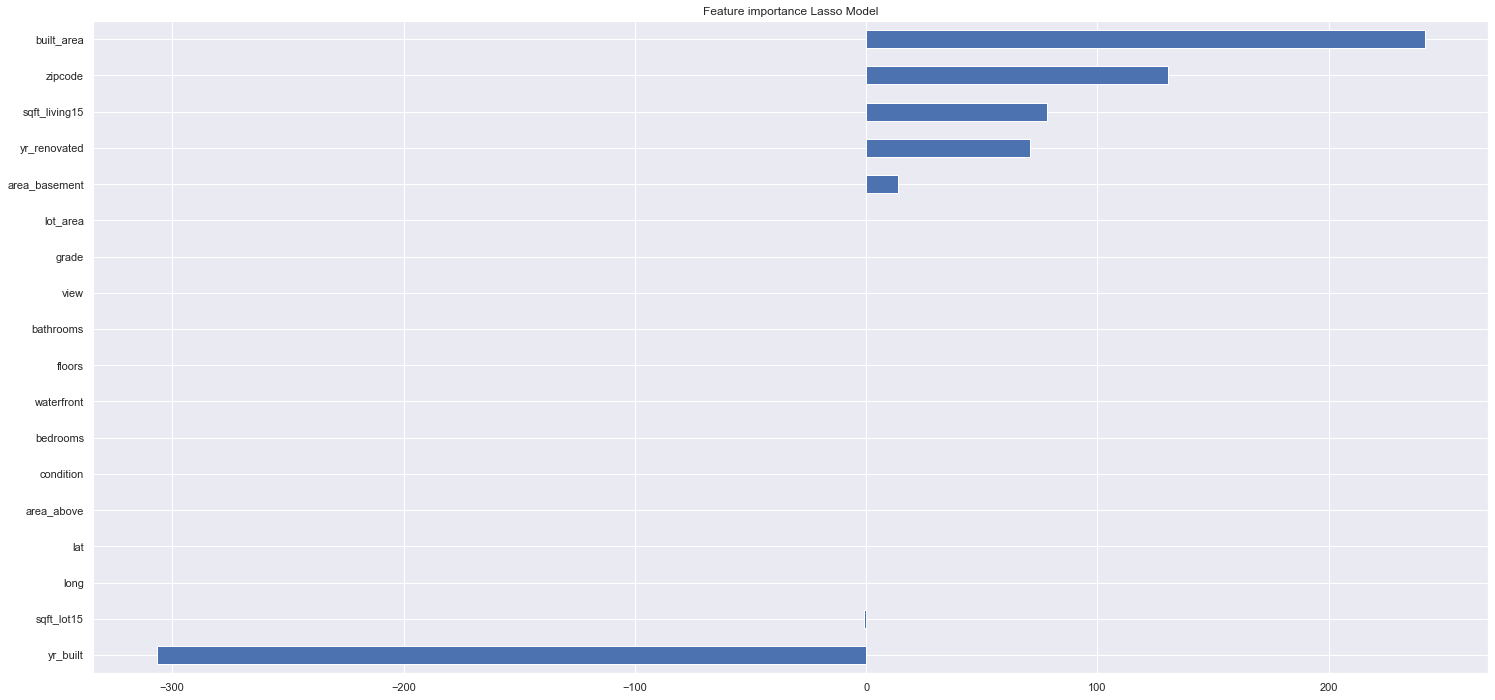

In [187]:
# Linear Regression - Lasso CV Regularization
reg = linear_model.LassoCV()

reg.fit( X_train, y_train)
print( 'Best Alpha using built-in LassoCV: {}'.format(reg.alpha_) )
print( 'Best score using built-in LassoCV: {}'.format(reg.score( X_train, y_train) ) )
coef = pd.Series(reg.coef_, index= X_train.columns)

cols_selected = list( coef[coef != 0 ].index)
print("Lasso picked " + str(sum(coef != 0) ) + " Variables and eliminated " + str(sum( coef == 0)) + " Variables.") 

#Plot importances
imp_coef = coef.sort_values()
imp_coef.plot(kind="barh")
plt.title("Feature importance Lasso Model")

## 5.3. Boruta Feature Selection

# 6.0. MACHINE LEARNING MODELLING
---

## 6.1. Average Model ( Baseline Model )

In [248]:
# dataset
aux = X_test.copy()
aux['sales'] = y_test.copy()

# predictions
yhat_baseline = aux['sales'].mean()

aux['prediction'] = yhat_baseline

# performance
baseline_result = ml_error( 'Average Model', aux['sales'], aux['prediction'] )
baseline_result

,Model,MAE,MAPE,RMSE
0,Average Model,227491.803417,0.523547,344853.982573


## 6.2. Linear Regression

In [254]:
# model
lr = LinearRegression().fit( X_train, y_train ) 

# predictions
yhat_lr = lr.predict( X_test )

# Performance
lr_result = ml_error( 'Linear Regression', y_test, yhat_lr ) 
lr_result

,Model,MAE,MAPE,RMSE
0,Linear Regression,122215.153776,0.2553,190499.231515


### 6.2.1. Cross-Validation

In [257]:
aux = pd.DataFrame()

kf = KFold( n_splits=10, random_state=42, shuffle=False )
for train_index, test_index in kf.split( X_train ):
    # dataset
    xtrain, xtest = X_train.iloc[train_index], X_train.iloc[test_index]
    ytrain, ytest = y_train.iloc[train_index], y_train.iloc[test_index]
    
    # model
    lr = LinearRegression().fit( xtrain, ytrain )
    
    # prediction
    yhat_lr = lr.predict( xtest )
    
    # performance
    lr_result = ml_error( 'Linear Regression', ytest, yhat_lr )
    aux = pd.concat( [aux, lr_result ] )
    
cv_result = pd.DataFrame( {'Model': 'Linear Regression', 
                           'AVG MAE':  str( np.round( aux['MAE'].mean(),  2 ) )  + ' +/- ' + str( np.round( aux['MAE'].std(), 2 ) ),
                           'AVG MAPE': str( np.round( aux['MAPE'].mean(), 2 ) )  + ' +/- ' + str( np.round( aux['MAPE'].std(), 2 ) ) ,
                           'AVG RMSE': str( np.round( aux['RMSE'].mean(), 2 ) )  + ' +/- ' + str( np.round( aux['RMSE'].std(), 2 ) ) }, index=[0] )

In [258]:
cv_result

,Model,AVG MAE,AVG MAPE,AVG RMSE
0,Linear Regression,127826.77 +/- 4522.83,0.26 +/- 0.01,203772.09 +/- 22382.18


## 6.3. Linear Regression Regularized - LASSO

In [95]:
# Compute MAE
scores = cross_val_score( lr, X_train, y_train, cv=5, scoring='neg_mean_absolute_error' )
avg_mae, std_mae = -scores.mean(), scores.std()

# Compute RMSE 
scores = cross_val_score( lr, X_train, y_train, cv=5, scoring='neg_mean_squared_error' )
avg_mse, std_mse = -scores.mean(), scores.std()

lr_result_cv = pd.DataFrame( {'Model': 'Linear Regression', 
                              'AVG MAE': str( np.round( avg_mae, 2 ) ) + ' +/- ' + str( np.round( std_mae ) ),
                              'AVG RMSE': str( np.round( np.sqrt( avg_mse ), 2 ) ) + ' +/- ' + str( np.round( np.sqrt( std_mse ) ) ) }, index=[0] )
lr_result_cv

,Model,AVG MAE,AVG RMSE
0,Linear Regression,127993.19 +/- 2818.0,205422.51 +/- 90974.0


## 6.4. Linear Regression Regularized - RIDGE

## 6.5. Linear Regression Regularized - Elastic Net

## 6.6. Polymonial Regression

In [61]:
#Polymonial
poly_reg = PolynomialFeatures(degree=4)
X_train_poly =poly_reg.fit_transform(X_train)
X_test_poly = poly_reg.fit_transform(X_test)


#Linear Regression
pol_reg = linear_model.LinearRegression()
pol_reg.fit(X_train_poly, y_train)

#predict
predi_poly = pol_reg.predict(X_test_poly)


#Performance
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, predi_poly))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, predi_poly))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, predi_poly)))

Mean Absolute Error: 403918.9614778424
Mean Squared Error: 188269354698109.03
Root Mean Squared Error: 13721128.040292788


In [46]:
X = np.array([[1,2], [3,4], [1,2], [3,4]])
y = np.array([1,2,3,4])
kf = KFold(n_splits=2)
kf.get_n_splits(X)

print(kf)

KFold(n_splits=2, random_state=None, shuffle=False)


In [47]:
for train_index, test_index in kf.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test= X[train_index], X[test_index]
    y_train, y_test= y[train_index], y[test_index]

TRAIN: [2 3] TEST: [0 1]
TRAIN: [0 1] TEST: [2 3]
